In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

## a demo of radar and large scale box

In [12]:
ds_cape = xr.open_dataset("/scratch/k10/dl6968/ERA5_AU/Darwin/small_clip/CAPE_bigger_clip.nc")

In [13]:
ds_radar = xr.open_dataset("/g/data/rq0/level_2/63/STEINER/63_20200301_steiner.nc")


/home/565/dl6968/miniconda3/envs/myenv/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:2009: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  result = super().pcolor(*args, **kwargs)


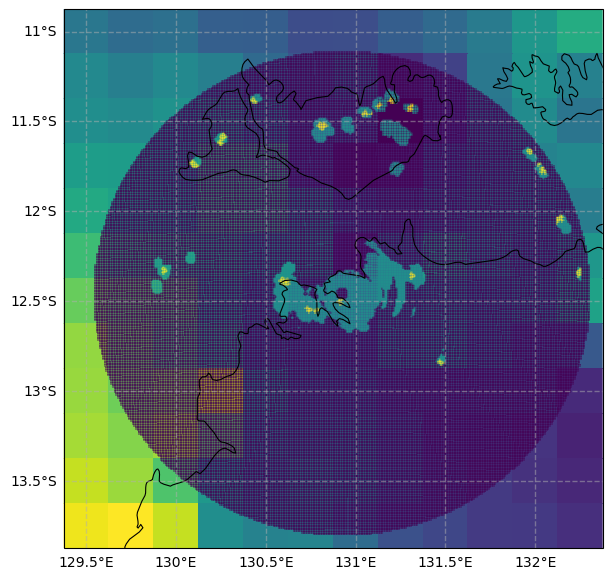

In [21]:
fig = plt.figure(figsize=(10, 7))
ax1 = fig.add_subplot(111, projection=ccrs.PlateCarree())
plt.pcolor(ds_cape.longitude, ds_cape.latitude, ds_cape["cape"].isel(time=0), transform=ccrs.PlateCarree())
plt.pcolor(ds_radar.longitude, ds_radar.latitude, ds_radar["steiner"].isel(time=0), alpha=0.4, transform=ccrs.PlateCarree(),rasterized=True)
ax1.coastlines('10m', color="black", linewidth=0.8)
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

## convert them to time series first

In [2]:
%%time
ds_cape = xr.open_dataset("/scratch/k10/dl6968/ERA5_AU/Darwin/small_clip/CAPE_bigger_clip.nc")
cape_ts = ds_cape["cape"].mean(dim=("longitude","latitude"))
ds_ts = cape_ts.sel(time=slice("2020-03-01","2021-03-01")).to_dataset(name="cape")
ds_ts.to_netcdf("/scratch/k10/dl6968/prep_hk25/environment/cape_hackathon_ts.nc")

CPU times: user 11.6 s, sys: 3.09 s, total: 14.6 s
Wall time: 22.4 s


In [3]:
var = ["cin", "w500", "rh500"]
ds_var = ["cin", "w", "rh"]
for i in range(0,len(var)):
    ds = xr.open_dataset(f"/scratch/k10/dl6968/ERA5_AU/Darwin/small_clip/{var[i]}_bigger_clip.nc")
    var_ts = ds[ds_var[i]].mean(dim=("longitude","latitude"))
    ds_ts = var_ts.sel(time=slice("2020-03-01","2021-03-01")).to_dataset(name=ds_var[i])
    ds_ts.to_netcdf(f"/scratch/k10/dl6968/prep_hk25/environment/{var[i]}_hackathon_ts.nc")


## linear interpolate to radar time 
so in high-res models the 3D field is 6 hourly and 2D precipitation is hourly (this might be needed)

In [14]:
var = ["cape","cin", "w500", "rh500"]
ds_radar = xr.open_mfdataset("/scratch/k10/dl6968/prep_hk25/steiner_ts/number_size_*.nc")
for i in range(0,len(var)):
    ds_env = xr.open_dataset(f"/scratch/k10/dl6968/prep_hk25/environment/{var[i]}_hackathon_ts.nc")
    ds_interp = ds_env.interp(time=ds_radar.time, method="linear")
    ds_interp.to_netcdf(f"/scratch/k10/dl6968/prep_hk25/environment/radar_time/{var[i]}_steiner_ts.nc")